# Intel Image Classification with PyTorch Lightning
**This notebook demonstrates how to build and train an image classification model using a pretrained ResNet18 on the Intel Image Classification dataset. We will leverage PyTorch Lightning to streamline the training process.**

# Import Libraries

First, we install PyTorch Lightning and import all the necessary libraries for data manipulation, model building, and visualization.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import glob
from PIL import Image
import matplotlib.pyplot as plt

# Data Exploration and Visualization
We'll start by loading the image paths and their corresponding labels into a Pandas DataFrame. This helps us organize the data and makes it easier to create our custom dataset later.

In [2]:
# Create DataFrames for training and testing datasets
train_data_path = glob.glob("dataset/seg_train/seg_train/*/*.jpg")
test_data_path = glob.glob("dataset/seg_test/seg_test/*/*.jpg")

train_df = pd.DataFrame({'path': train_data_path})
train_df['label'] = train_df['path'].apply(lambda x: x.split('/')[-2])

test_df = pd.DataFrame({'path': test_data_path})
test_df['label'] = test_df['path'].apply(lambda x: x.split('/')[-2])

Let's visualize a few sample images from the training set to get a feel for the data.



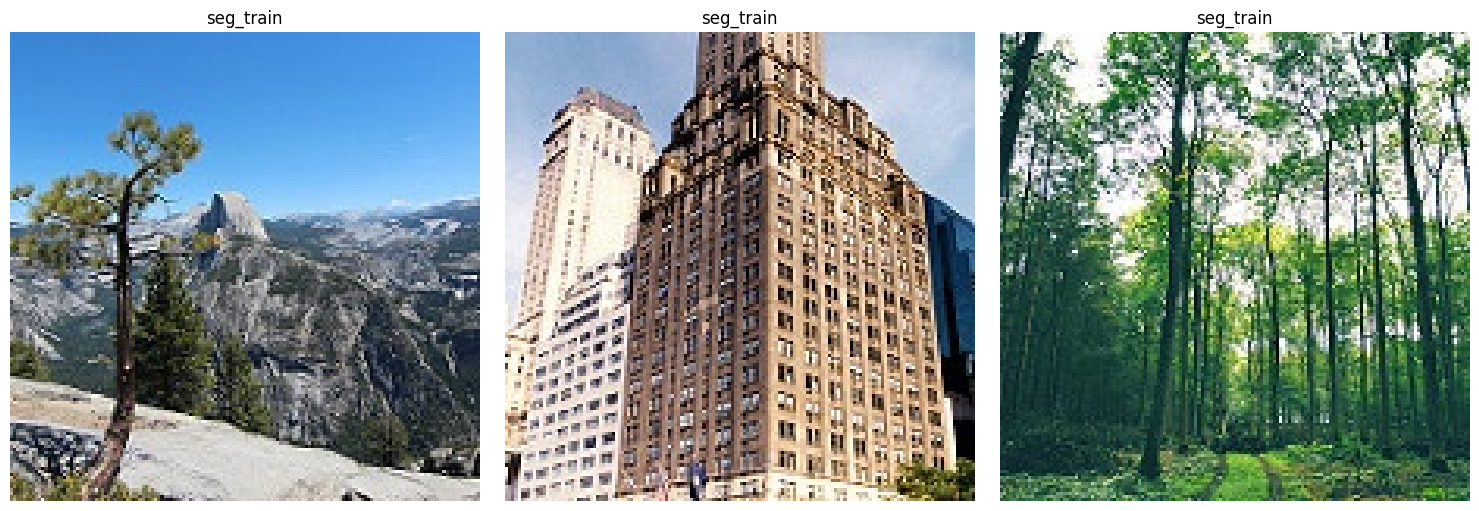

In [4]:
# Display 3 random images from the training set
plt.figure(figsize=(15, 5))

num_sample = 0
for _, row in train_df.sample(n=3).iterrows():
    image = Image.open(row['path'])
    plt.subplot(1, 3, num_sample + 1)
    plt.imshow(image)
    plt.title(row['label'])
    plt.axis('off')
    num_sample += 1

plt.tight_layout()
plt.show()

# Data Preparation

We define a custom Dataset class to load our images. This class takes a DataFrame, reads each image from its path, applies the necessary transformations, and returns the image tensor and its corresponding label index.

In [5]:
class ImageDataset(Dataset):
    """Custom PyTorch Dataset for loading images from a DataFrame."""
    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing image paths and labels.
            transform (torchvision.transforms.Compose, optional): Transformations to apply to each image.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(self.df['label'].unique())
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.df)

    def __getitem__(self, idx):
        """
        Fetches the sample at the given index.

        Args:
            idx (int): The index of the sample.

        Returns:
            tuple: (torch.Tensor, int) where the tensor is the transformed image
                   and the int is the label index.
        """
        row = self.df.iloc[idx]
        path = row['path']
        label = self.class_to_idx[row['label']]
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

#  Lightning DataModule

A `LightningDataModule` encapsulates all the steps needed to prepare data for training and validation. It defines the datasets, transformations, and data loaders. This keeps our data-related code organized and reusable.

In [ ]:
class IntelImageDataModule(L.LightningDataModule):
    """LightningDataModule for the Intel Image Classification dataset."""
    def __init__(self, train_df, test_df, batch_size=32, num_workers=2):
        """
        Args:
            train_df (pd.DataFrame): DataFrame for the training data.
            test_df (pd.DataFrame): DataFrame for the testing/validation data.
            batch_size (int): Number of samples per batch.
            num_workers (int): Number of subprocesses to use for data loading.
        """
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Define transformations for training and validation sets
        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def setup(self, stage=None):
        """Assigns train/val datasets for use in dataloaders."""
        self.train_dataset = ImageDataset(self.train_df, transform=self.train_transform)
        self.val_dataset = ImageDataset(self.test_df, transform=self.test_transform)
        self.num_classes = len(self.train_dataset.classes)

    def train_dataloader(self):
        """Returns the training dataloader."""
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        """Returns the validation dataloader."""
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=True)

#  Model Definition
Here, we define our `LightningModule`. This class uses a pretrained `ResNet18` model from torchvision. We replace the final fully connected layer to match the number of classes in our dataset (6). The module also contains the logic for the training step, validation step, and optimizer configuration.

In [7]:
class ResNetClassifier(L.LightningModule):
    """LightningModule for a pretrained ResNet18 classifier."""
    def __init__(self, num_classes):
        """
        Args:
            num_classes (int): The number of output classes.
        """
        super().__init__()
        self.num_classes = num_classes
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Freeze all the parameters in the feature extraction part of the model
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the classifier layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, self.num_classes)

    def forward(self, x):
        """Defines the forward pass of the model."""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Defines the training logic for a single step."""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """Defines the validation logic for a single step."""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        """Configures the optimizer for the model."""
        # We only optimize the parameters of the new classifier layer
        return torch.optim.Adam(self.model.fc.parameters(), lr=1e-3)

# Training the Model

Finally, we instantiate our `IntelImageDataModule` and `ResNetClassifier`. We then create a `Trainer` instance, configure it to run for 5 epochs, and call `trainer.fit()` to start the training process. PyTorch Lightning handles the entire training loop for us.

In [ ]:
# Initialize the DataModule
dm = IntelImageDataModule(train_df, test_df)
dm.setup()

# Initialize the model with the correct number of classes from the DataModule
model = ResNetClassifier(num_classes=dm.num_classes)

# Initialize the Trainer and start training
trainer = L.Trainer(max_epochs=5)
trainer.fit(model, datamodule=dm)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s] 
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-08-06 16:06:40.893689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754496401.095888      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754496401.153654      36 cuda_blas.cc:1418] Unable to register cuBLAS f

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.


In [22]:
trainer.validate(model, datamodule=dm) 

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076666831970215     │
│         val_loss          │    0.24393433332443237    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.24393433332443237, 'val_acc': 0.9076666831970215}]

## Train with logger

In [ ]:
# Initialize the DataModule
dm = IntelImageDataModule(train_df, test_df)
dm.setup()

# Initialize the model with the correct number of classes from the DataModule
model = ResNetClassifier(num_classes=dm.num_classes)

# Initialize the Trainer and start training
trainer = L.Trainer(max_epochs=5, logger=L.pytorch.loggers.TensorBoardLogger("logs/", name="intel", version=1),)
trainer.fit(model, datamodule=dm)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:33<00:00, 1.39MB/s]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
513       Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\ASUS\miniconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
